*주택 가격 예측하기*<br/>



설명 변수 [79개] <br/>
이 데이터를 바탕으로 모델 작성 후에 1459채 가격 예측<br/>
연속적인 값을 예측하는 회귀분석을 사용함.<br/>
RMSE = Root Mean Squared Error<br/>
RMSE를 사용할 때는 예측값과 실제 값 차이가 너무 큰 데이터가 포함되어 있으면 다른 예측값의 정확도가 아무리 좋아도 전체 예측 정확도가 크게 영향을 받음. <br/>
반면 실제 값 예측 값 각각에 로그를 취하면 각 데이터 간 차이가 작아져 특정 데이터가 전체 평가에 영향을 미치는 정도를 줄일 . 수있음.
예측 정확도를 확인할 때는 로그를 취해야 한다는 것을 잊지 맙시다.<br/>


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use("ggplot")

In [4]:
import pandas as pd
import numpy as np

In [5]:
import random
np.random.seed(1234)
random.seed(1234)
# random seed를 설정하는 이유 : 실험의 재현성을 위함.

In [6]:
train_df = pd.read_csv('./data_set/train.csv')
test_df = pd.read_csv('./data_set/test.csv')
submission = pd.read_csv('./data_set/sample_submission.csv')

In [11]:
train_df.shape

(1460, 81)

lightgbm으로 예측

각 변수의 중요도를 나타낼 수 있기 때문

In [14]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [16]:
train_df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [17]:
# 전처리를 위해 train, test를 합친다.
all_df = pd.concat([train_df, test_df], sort=False).reset_index()

In [19]:
all_df

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [20]:
from sklearn.preprocessing import LabelEncoder

In [22]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [23]:
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [24]:
for cate in categories:
    le = LabelEncoder()
    print(cate)

    all_df[cate].fillna('missing', inplace=True) # 원본 데이터 프레임을 바꿀 것인지 말것인지를 설정할 수 있음.
    le = le.fit(all_df[cate])
    all_df[cate] = le.transform(all_df[cate])
    all_df[cate] = all_df[cate].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


/var/folders/d4/4wc2d_0j5vv5zqznm4l6905c0000gn/T/ipykernel_7962/3337899386.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cate].fillna('missing', inplace=True) # 원본 데이터 프레임을 바꿀 것인지 말것인지를 설정할 수 있음.
/var/folders/d4/4wc2d_0j5vv5zqznm4l6905c0000gn/T/ipykernel_7962/3337899386.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [25]:
all_df

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,3,65.0,8450,1,2,3,3,...,0,3,4,4,0,2,2008,8,4,208500.0
1,1,2,20,3,80.0,9600,1,2,3,3,...,0,3,4,4,0,5,2007,8,4,181500.0
2,2,3,60,3,68.0,11250,1,2,0,3,...,0,3,4,4,0,9,2008,8,4,223500.0
3,3,4,70,3,60.0,9550,1,2,0,3,...,0,3,4,4,0,2,2006,8,0,140000.0
4,4,5,60,3,84.0,14260,1,2,0,3,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,4,21.0,1936,1,2,3,3,...,0,3,4,4,0,6,2006,8,4,NaN
2915,1455,2916,160,4,21.0,1894,1,2,3,3,...,0,3,4,4,0,4,2006,8,0,NaN
2916,1456,2917,20,3,160.0,20000,1,2,3,3,...,0,3,4,4,0,9,2006,8,0,NaN
2917,1457,2918,85,3,62.0,10441,1,2,3,3,...,0,3,2,2,700,7,2006,8,4,NaN


In [26]:
# 학습데이터와 테스트데이터로 되돌리기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [27]:
# lightgbm으로 데이터 읽기
import lightgbm as lgb


In [29]:
# 교차검증용 라이브러리 설정
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [30]:
# 하이퍼파리미터 설정
lgbm_params = {
    "objective" : "regression",
    "randome_seed" : 1234
}

In [31]:
# 설명 변수와 목적 변수 지정
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [32]:
# 평균 제곱 오차 라이브러리
from sklearn.metrics import mean_squared_error

In [33]:
# fold별로 작성한 모델을 models에 저장.
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train, 
                          valid_sets=lgb_eval
                          )
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 75
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Start training from score 179726.031860
0.12825706698915337
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the

In [35]:
sum(rmses)/len(rmses)
from statistics import mean
mean(rmses)

np.float64(0.13610045052556563)

In [36]:
# 현재 예측값과 실제 값 차이 확인하기
actual_pred_df = pd.DataFrame({
    "actual": train_Y,
    "pred": oof
})

<Axes: >

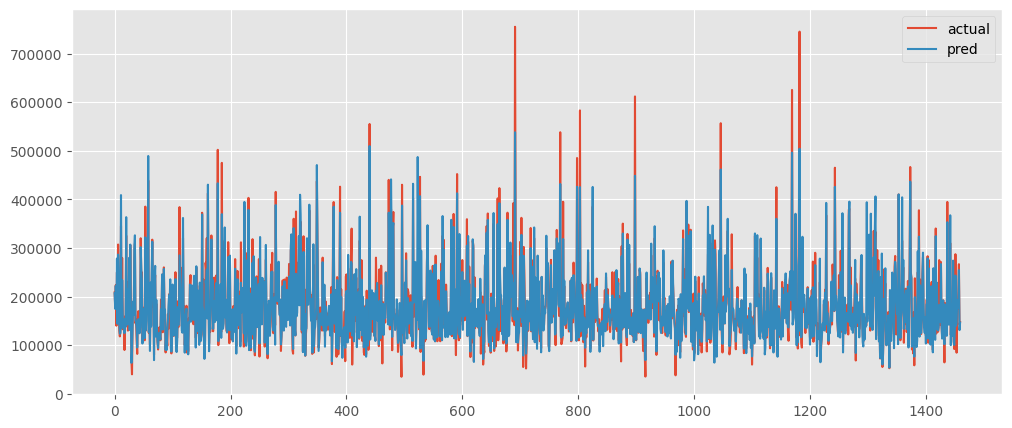

In [37]:
actual_pred_df.plot(figsize=(12,5))